In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from src.utils import visualize_metrics

In [2]:
# Reading the data
data = pd.read_csv("scripts/crops.csv", sep=",")
features = data[data.columns[:-1]]
labels = data[data.columns[-1]]

# Stratified splitting for train and test
# Stratified means that it maintains similar distributions of classes for both train and test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42, stratify=labels
)

# Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

#### Testing parameters:

    Estimators = 1000
    seed = 0
    Depth = 5, 10, None
    Resampling_Strategy = "all"


Unbalanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = all

Accuracy: 0.8032786885245902 
Precision: 0.5367373153500321 
Recall: 0.41295057599405427 
F1 Score: 0.4312933190425151 
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.79      1.00      0.88       276
           2       0.00      0.00      0.00        32
           3       0.89      0.22      0.36        36
           4       1.00      0.85      0.92        13

    accuracy                           0.80       366
   macro avg       0.54      0.41      0.43       366
weighted avg       0.72      0.80      0.73       366



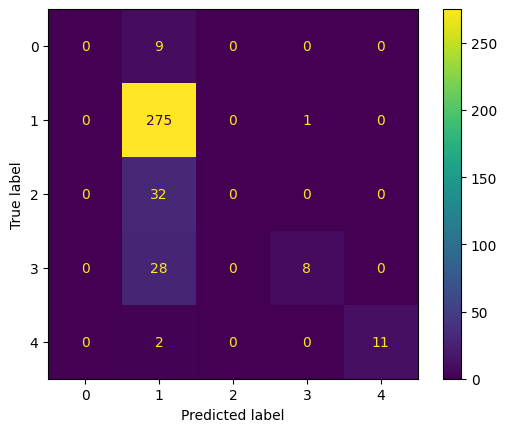

Semi-balanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = all

Accuracy: 0.5519125683060109 
Precision: 0.4991117567735709 
Recall: 0.7265096618357487 
F1 Score: 0.525036749044247 
Classification Report:
               precision    recall  f1-score   support

           0       0.24      1.00      0.39         9
           1       0.95      0.51      0.67       276
           2       0.16      0.56      0.25        32
           3       0.43      0.56      0.48        36
           4       0.72      1.00      0.84        13

    accuracy                           0.55       366
   macro avg       0.50      0.73      0.53       366
weighted avg       0.80      0.55      0.61       366



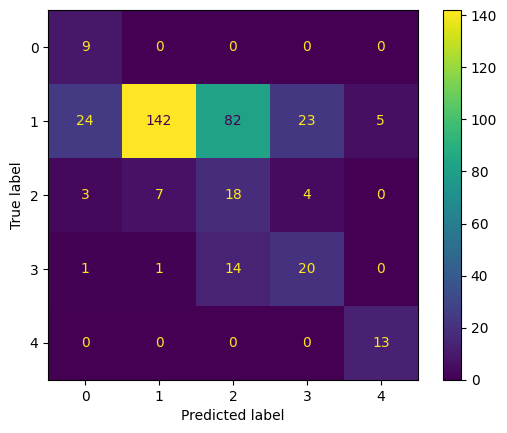

Balanced Dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = all

Accuracy: 0.674863387978142 
Precision: 0.6470301003344481 
Recall: 0.7542874396135265 
F1 Score: 0.6460050149091894 
Classification Report:
               precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.94      0.68      0.79       276
           2       0.17      0.56      0.26        32
           3       0.73      0.53      0.61        36
           4       1.00      1.00      1.00        13

    accuracy                           0.67       366
   macro avg       0.65      0.75      0.65       366
weighted avg       0.84      0.67      0.73       366



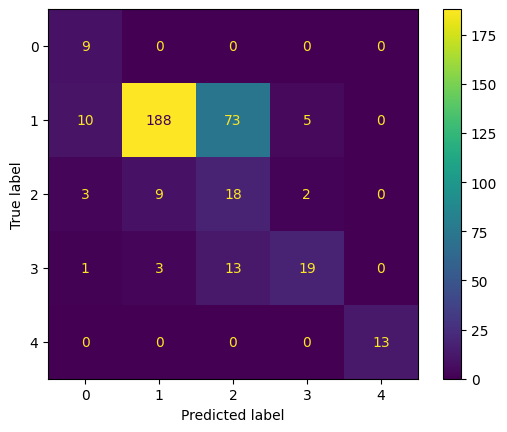

Unbalanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = all

Accuracy: 0.8387978142076503 
Precision: 0.7534004592828122 
Recall: 0.5548309178743962 
F1 Score: 0.6013786907085541 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       0.00      0.00      0.00        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.75      0.55      0.60       366
weighted avg       0.78      0.84      0.79       366



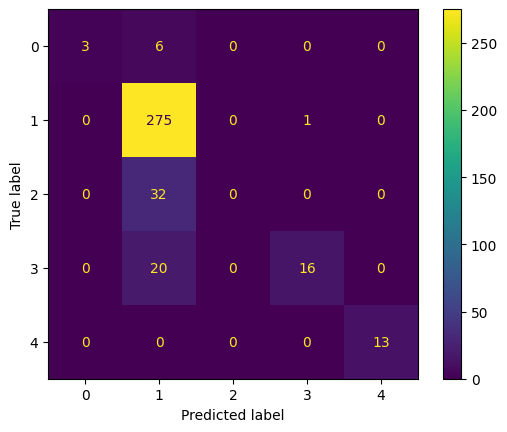

Semi-balanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = all

Accuracy: 0.6311475409836066 
Precision: 0.5297477629817516 
Recall: 0.7958333333333334 
F1 Score: 0.577897322000708 
Classification Report:
               precision    recall  f1-score   support

           0       0.23      1.00      0.37         9
           1       0.96      0.58      0.73       276
           2       0.22      0.56      0.31        32
           3       0.53      0.83      0.65        36
           4       0.72      1.00      0.84        13

    accuracy                           0.63       366
   macro avg       0.53      0.80      0.58       366
weighted avg       0.82      0.63      0.68       366



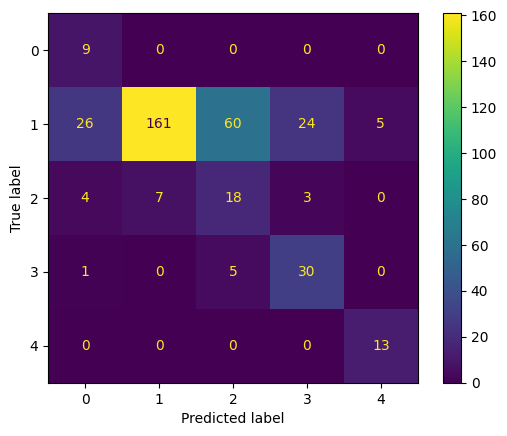

Balanced Dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = all

Accuracy: 0.8497267759562842 
Precision: 0.8328690904463905 
Recall: 0.8172101449275363 
F1 Score: 0.8211908903181875 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      0.90      0.91       276
           2       0.32      0.44      0.37        32
           3       0.93      0.75      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.85       366
   macro avg       0.83      0.82      0.82       366
weighted avg       0.87      0.85      0.86       366



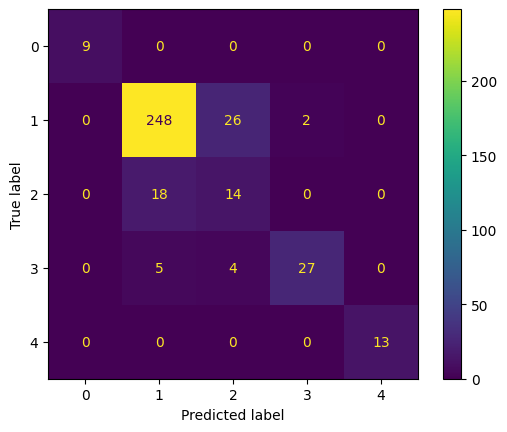

Unbalanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = all

Accuracy: 0.8415300546448088 
Precision: 0.9538979447200567 
Recall: 0.5610809178743962 
F1 Score: 0.613796981733923 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       1.00      0.03      0.06        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.95      0.56      0.61       366
weighted avg       0.86      0.84      0.79       366



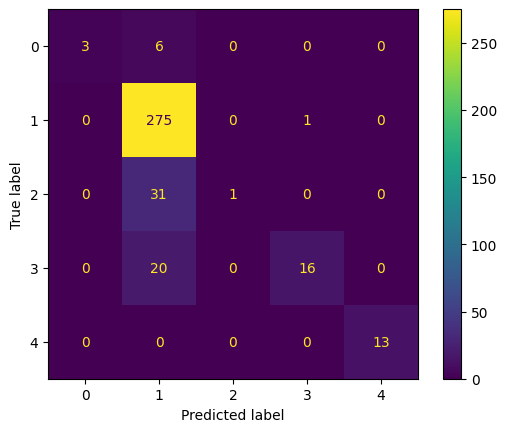

Semi-balanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = all

Accuracy: 0.6366120218579235 
Precision: 0.5339576736251808 
Recall: 0.8028079710144927 
F1 Score: 0.5820362177166596 
Classification Report:
               precision    recall  f1-score   support

           0       0.23      1.00      0.37         9
           1       0.97      0.59      0.73       276
           2       0.23      0.59      0.33        32
           3       0.53      0.83      0.65        36
           4       0.72      1.00      0.84        13

    accuracy                           0.64       366
   macro avg       0.53      0.80      0.58       366
weighted avg       0.83      0.64      0.68       366



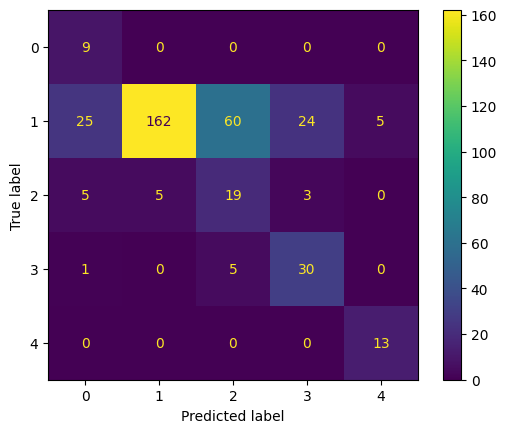

Balanced Dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = all

Accuracy: 0.8934426229508197 
Precision: 0.8895729847494553 
Recall: 0.8018719806763286 
F1 Score: 0.8335175736961451 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.90      0.97      0.93       276
           2       0.59      0.31      0.41        32
           3       0.96      0.72      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.89       366
   macro avg       0.89      0.80      0.83       366
weighted avg       0.88      0.89      0.88       366



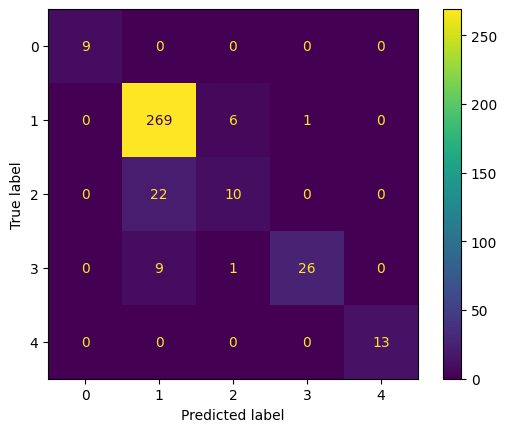

In [3]:
# Training both balanced and unbalanced datasets with a stratifying random forest
ests = 1000
seed = 0
depth = 5
strat = "all"

clf_unbalanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced.fit(X_train, y_train)
print("Unbalanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced, X_test, y_test)

clf_semibalanced = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced.fit(X_train, y_train)
print("Semi-balanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced, X_test, y_test)

clf_balanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced.fit(X_res, y_res)
print("Balanced Dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced, X_test, y_test)

ests = 1000
seed = 0
depth = 10
strat = "all"

clf_unbalanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced2.fit(X_train, y_train)
print("Unbalanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced2, X_test, y_test)

clf_semibalanced2 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced2.fit(X_train, y_train)
print("Semi-balanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced2, X_test, y_test)

clf_balanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced2.fit(X_res, y_res)
print("Balanced Dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced2, X_test, y_test)

ests = 1000
seed = 0
depth = None
strat = "all"

clf_unbalanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced3.fit(X_train, y_train)
print("Unbalanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced3, X_test, y_test)

clf_semibalanced3 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced3.fit(X_train, y_train)
print("Semi-balanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced3, X_test, y_test)

clf_balanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced3.fit(X_res, y_res)
print("Balanced Dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced3, X_test, y_test)

#### Testing parameters:

    Estimators = 1000
    seed = 0
    Depth = 5, 10, None
    Resampling_Strategy = "auto"


Unbalanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = auto

Accuracy: 0.8032786885245902 
Precision: 0.5367373153500321 
Recall: 0.41295057599405427 
F1 Score: 0.4312933190425151 
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.79      1.00      0.88       276
           2       0.00      0.00      0.00        32
           3       0.89      0.22      0.36        36
           4       1.00      0.85      0.92        13

    accuracy                           0.80       366
   macro avg       0.54      0.41      0.43       366
weighted avg       0.72      0.80      0.73       366



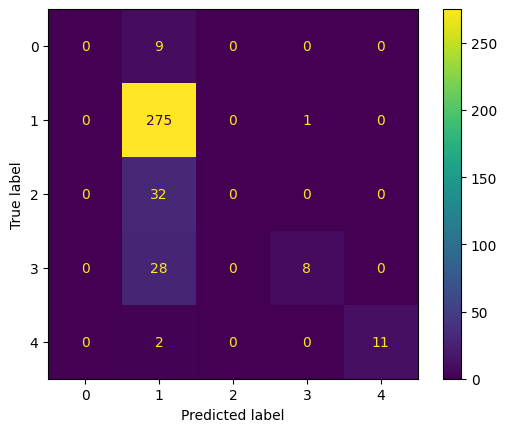

Semi-balanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = auto

Accuracy: 0.5327868852459017 
Precision: 0.49392930164206766 
Recall: 0.720048309178744 
F1 Score: 0.5099133826155604 
Classification Report:
               precision    recall  f1-score   support

           0       0.19      1.00      0.32         9
           1       0.96      0.49      0.65       276
           2       0.14      0.50      0.22        32
           3       0.46      0.61      0.52        36
           4       0.72      1.00      0.84        13

    accuracy                           0.53       366
   macro avg       0.49      0.72      0.51       366
weighted avg       0.81      0.53      0.60       366



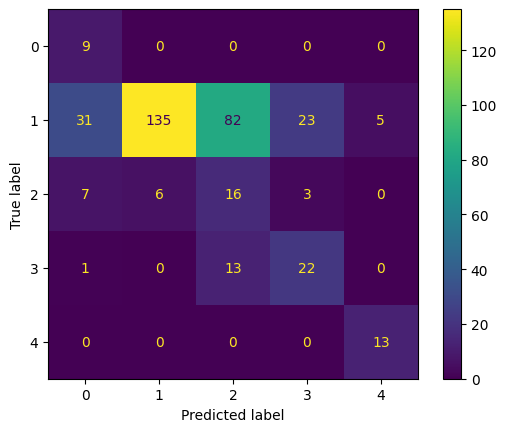

Balanced Dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = auto

Accuracy: 0.674863387978142 
Precision: 0.6470301003344481 
Recall: 0.7542874396135265 
F1 Score: 0.6460050149091894 
Classification Report:
               precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.94      0.68      0.79       276
           2       0.17      0.56      0.26        32
           3       0.73      0.53      0.61        36
           4       1.00      1.00      1.00        13

    accuracy                           0.67       366
   macro avg       0.65      0.75      0.65       366
weighted avg       0.84      0.67      0.73       366



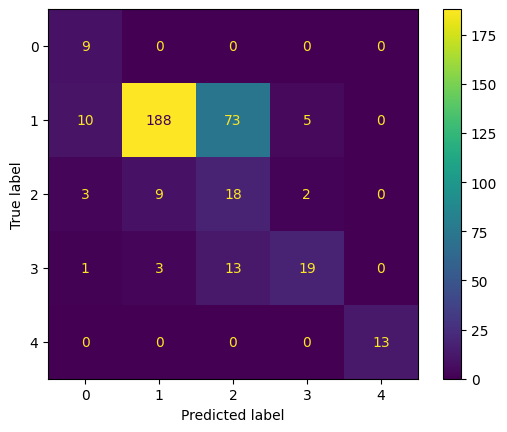

Unbalanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = auto

Accuracy: 0.8387978142076503 
Precision: 0.7534004592828122 
Recall: 0.5548309178743962 
F1 Score: 0.6013786907085541 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       0.00      0.00      0.00        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.75      0.55      0.60       366
weighted avg       0.78      0.84      0.79       366



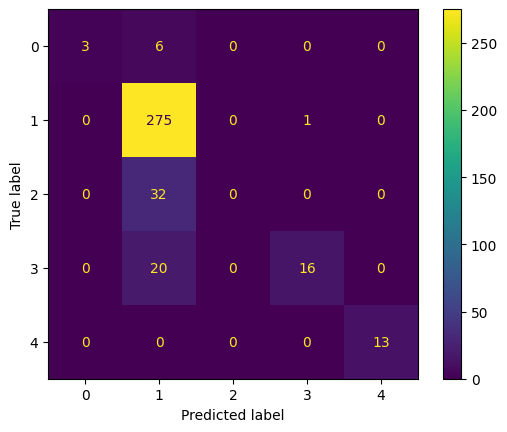

Semi-balanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = auto

Accuracy: 0.6065573770491803 
Precision: 0.5116811400407488 
Recall: 0.7886171497584541 
F1 Score: 0.5523438542954124 
Classification Report:
               precision    recall  f1-score   support

           0       0.18      1.00      0.31         9
           1       0.98      0.55      0.71       276
           2       0.21      0.53      0.30        32
           3       0.50      0.86      0.63        36
           4       0.68      1.00      0.81        13

    accuracy                           0.61       366
   macro avg       0.51      0.79      0.55       366
weighted avg       0.84      0.61      0.66       366



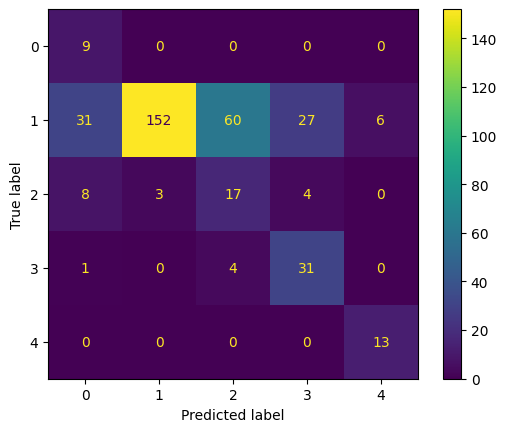

Balanced Dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = auto

Accuracy: 0.8497267759562842 
Precision: 0.8328690904463905 
Recall: 0.8172101449275363 
F1 Score: 0.8211908903181875 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      0.90      0.91       276
           2       0.32      0.44      0.37        32
           3       0.93      0.75      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.85       366
   macro avg       0.83      0.82      0.82       366
weighted avg       0.87      0.85      0.86       366



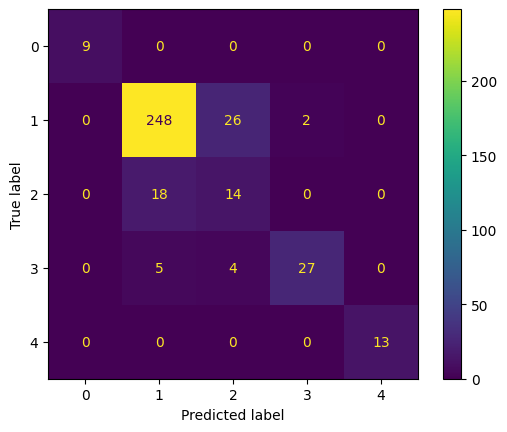

Unbalanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = auto

Accuracy: 0.8415300546448088 
Precision: 0.9538979447200567 
Recall: 0.5610809178743962 
F1 Score: 0.613796981733923 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       1.00      0.03      0.06        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.95      0.56      0.61       366
weighted avg       0.86      0.84      0.79       366



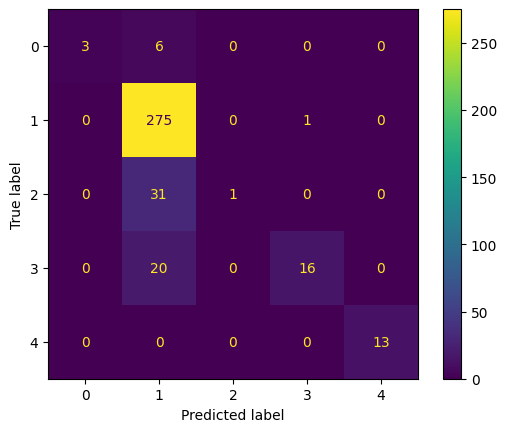

Semi-balanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = auto

Accuracy: 0.6120218579234973 
Precision: 0.5139689371038727 
Recall: 0.7852355072463768 
F1 Score: 0.5549342667679529 
Classification Report:
               precision    recall  f1-score   support

           0       0.18      1.00      0.31         9
           1       0.97      0.56      0.71       276
           2       0.21      0.53      0.30        32
           3       0.52      0.83      0.64        36
           4       0.68      1.00      0.81        13

    accuracy                           0.61       366
   macro avg       0.51      0.79      0.55       366
weighted avg       0.83      0.61      0.66       366



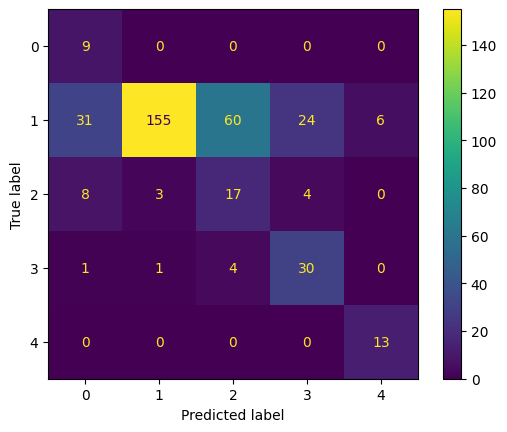

Balanced Dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = auto

Accuracy: 0.8934426229508197 
Precision: 0.8895729847494553 
Recall: 0.8018719806763286 
F1 Score: 0.8335175736961451 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.90      0.97      0.93       276
           2       0.59      0.31      0.41        32
           3       0.96      0.72      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.89       366
   macro avg       0.89      0.80      0.83       366
weighted avg       0.88      0.89      0.88       366



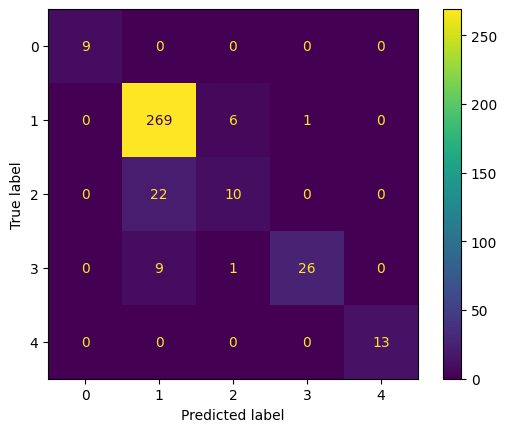

In [4]:
# Training both balanced and unbalanced datasets with a stratifying random forest
ests = 1000
seed = 0
depth = 5
strat = "auto"

clf_unbalanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced.fit(X_train, y_train)
print("Unbalanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced, X_test, y_test)

clf_semibalanced = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced.fit(X_train, y_train)
print("Semi-balanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced, X_test, y_test)

clf_balanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced.fit(X_res, y_res)
print("Balanced Dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced, X_test, y_test)

ests = 1000
seed = 0
depth = 10
strat = "auto"

clf_unbalanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced2.fit(X_train, y_train)
print("Unbalanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced2, X_test, y_test)

clf_semibalanced2 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced2.fit(X_train, y_train)
print("Semi-balanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced2, X_test, y_test)

clf_balanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced2.fit(X_res, y_res)
print("Balanced Dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced2, X_test, y_test)

ests = 1000
seed = 0
depth = None
strat = "auto"

clf_unbalanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced3.fit(X_train, y_train)
print("Unbalanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced3, X_test, y_test)

clf_semibalanced3 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced3.fit(X_train, y_train)
print("Semi-balanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced3, X_test, y_test)

clf_balanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced3.fit(X_res, y_res)
print("Balanced Dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced3, X_test, y_test)

#### Testing parameters:

    Estimators = 1000
    seed = 0
    Depth = 5, 10, None
    Resampling_Strategy = "not minority"


Unbalanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = not minority

Accuracy: 0.8032786885245902 
Precision: 0.5367373153500321 
Recall: 0.41295057599405427 
F1 Score: 0.4312933190425151 
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.79      1.00      0.88       276
           2       0.00      0.00      0.00        32
           3       0.89      0.22      0.36        36
           4       1.00      0.85      0.92        13

    accuracy                           0.80       366
   macro avg       0.54      0.41      0.43       366
weighted avg       0.72      0.80      0.73       366



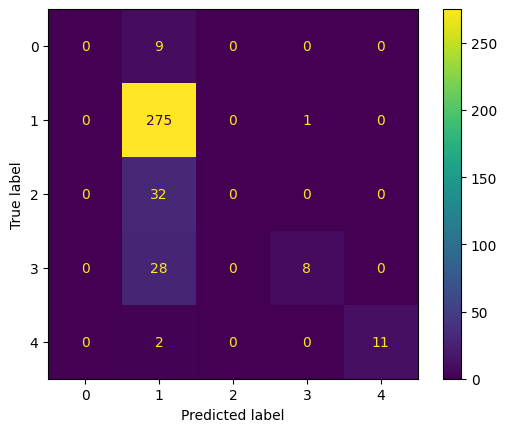

Semi-balanced dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = not minority

Accuracy: 0.5327868852459017 
Precision: 0.49392930164206766 
Recall: 0.720048309178744 
F1 Score: 0.5099133826155604 
Classification Report:
               precision    recall  f1-score   support

           0       0.19      1.00      0.32         9
           1       0.96      0.49      0.65       276
           2       0.14      0.50      0.22        32
           3       0.46      0.61      0.52        36
           4       0.72      1.00      0.84        13

    accuracy                           0.53       366
   macro avg       0.49      0.72      0.51       366
weighted avg       0.81      0.53      0.60       366



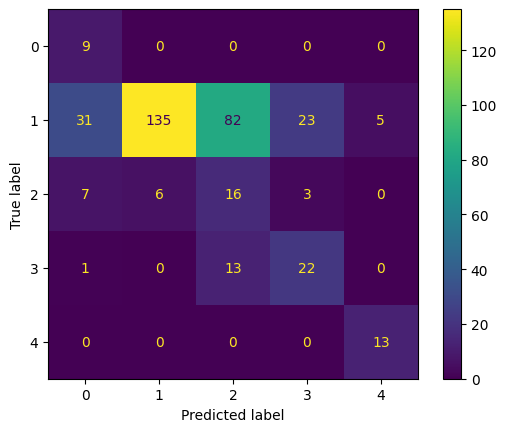

Balanced Dataset 1
estimators = 1000
seed = 0
depth = 5
resampling_strategy = not minority

Accuracy: 0.674863387978142 
Precision: 0.6470301003344481 
Recall: 0.7542874396135265 
F1 Score: 0.6460050149091894 
Classification Report:
               precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.94      0.68      0.79       276
           2       0.17      0.56      0.26        32
           3       0.73      0.53      0.61        36
           4       1.00      1.00      1.00        13

    accuracy                           0.67       366
   macro avg       0.65      0.75      0.65       366
weighted avg       0.84      0.67      0.73       366



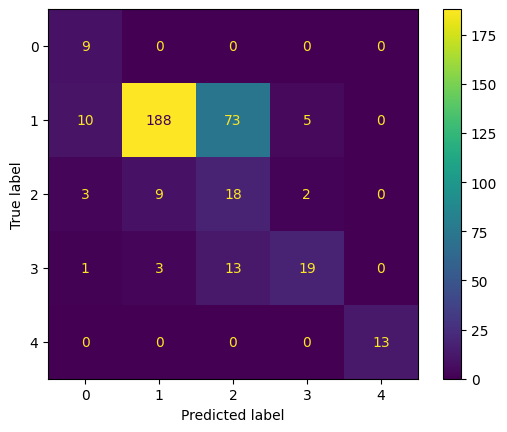

Unbalanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = not minority

Accuracy: 0.8387978142076503 
Precision: 0.7534004592828122 
Recall: 0.5548309178743962 
F1 Score: 0.6013786907085541 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       0.00      0.00      0.00        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.75      0.55      0.60       366
weighted avg       0.78      0.84      0.79       366



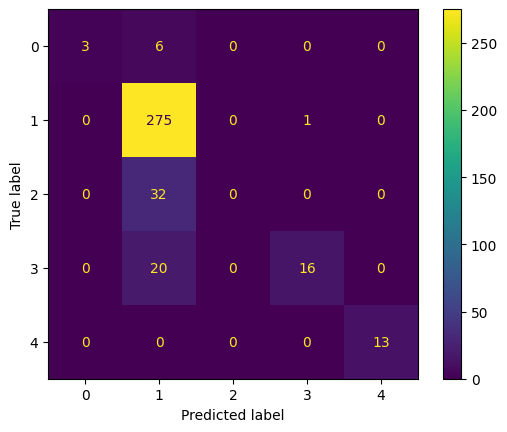

Semi-balanced dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = not minority

Accuracy: 0.6065573770491803 
Precision: 0.5116811400407488 
Recall: 0.7886171497584541 
F1 Score: 0.5523438542954124 
Classification Report:
               precision    recall  f1-score   support

           0       0.18      1.00      0.31         9
           1       0.98      0.55      0.71       276
           2       0.21      0.53      0.30        32
           3       0.50      0.86      0.63        36
           4       0.68      1.00      0.81        13

    accuracy                           0.61       366
   macro avg       0.51      0.79      0.55       366
weighted avg       0.84      0.61      0.66       366



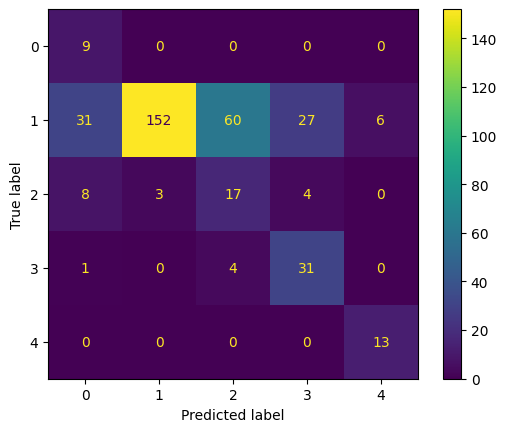

Balanced Dataset 2
estimators = 1000
seed = 0
depth = 10
resampling_strategy = not minority

Accuracy: 0.8497267759562842 
Precision: 0.8328690904463905 
Recall: 0.8172101449275363 
F1 Score: 0.8211908903181875 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      0.90      0.91       276
           2       0.32      0.44      0.37        32
           3       0.93      0.75      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.85       366
   macro avg       0.83      0.82      0.82       366
weighted avg       0.87      0.85      0.86       366



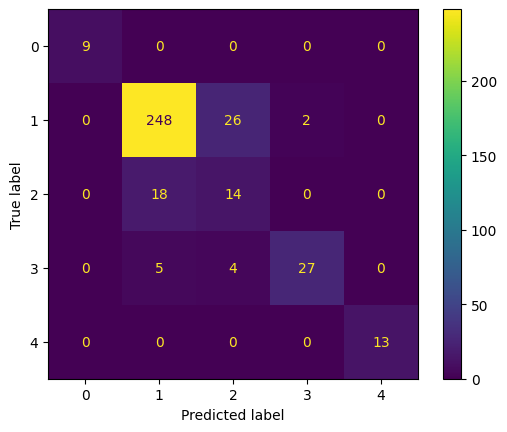

Unbalanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = not minority

Accuracy: 0.8415300546448088 
Precision: 0.9538979447200567 
Recall: 0.5610809178743962 
F1 Score: 0.613796981733923 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.83      1.00      0.90       276
           2       1.00      0.03      0.06        32
           3       0.94      0.44      0.60        36
           4       1.00      1.00      1.00        13

    accuracy                           0.84       366
   macro avg       0.95      0.56      0.61       366
weighted avg       0.86      0.84      0.79       366



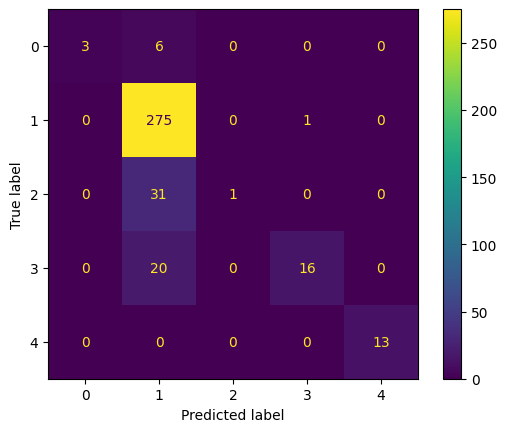

Semi-balanced dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = not minority

Accuracy: 0.6120218579234973 
Precision: 0.5139689371038727 
Recall: 0.7852355072463768 
F1 Score: 0.5549342667679529 
Classification Report:
               precision    recall  f1-score   support

           0       0.18      1.00      0.31         9
           1       0.97      0.56      0.71       276
           2       0.21      0.53      0.30        32
           3       0.52      0.83      0.64        36
           4       0.68      1.00      0.81        13

    accuracy                           0.61       366
   macro avg       0.51      0.79      0.55       366
weighted avg       0.83      0.61      0.66       366



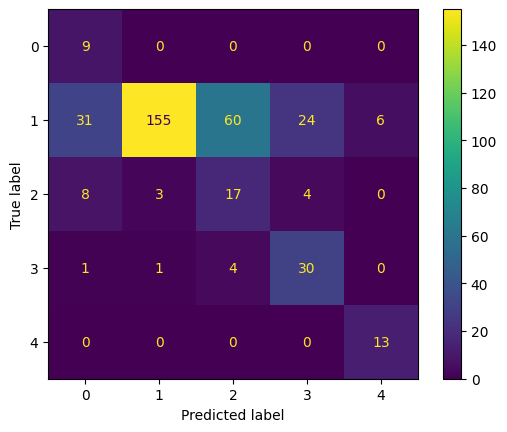

Balanced Dataset 3
estimators = 1000
seed = 0
depth = None
resampling_strategy = not minority

Accuracy: 0.8934426229508197 
Precision: 0.8895729847494553 
Recall: 0.8018719806763286 
F1 Score: 0.8335175736961451 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.90      0.97      0.93       276
           2       0.59      0.31      0.41        32
           3       0.96      0.72      0.83        36
           4       1.00      1.00      1.00        13

    accuracy                           0.89       366
   macro avg       0.89      0.80      0.83       366
weighted avg       0.88      0.89      0.88       366



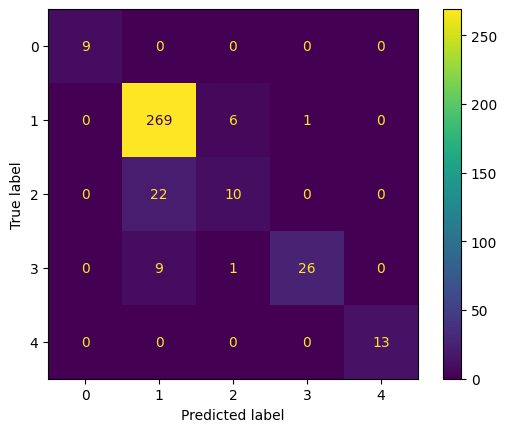

In [5]:
# Training both balanced and unbalanced datasets with a stratifying random forest
ests = 1000
seed = 0
depth = 5
strat = "not minority"

clf_unbalanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced.fit(X_train, y_train)
print("Unbalanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced, X_test, y_test)

clf_semibalanced = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced.fit(X_train, y_train)
print("Semi-balanced dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced, X_test, y_test)

clf_balanced = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced.fit(X_res, y_res)
print("Balanced Dataset 1")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced, X_test, y_test)

ests = 1000
seed = 0
depth = 10
strat = "not minority"

clf_unbalanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced2.fit(X_train, y_train)
print("Unbalanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced2, X_test, y_test)

clf_semibalanced2 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced2.fit(X_train, y_train)
print("Semi-balanced dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced2, X_test, y_test)

clf_balanced2 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced2.fit(X_res, y_res)
print("Balanced Dataset 2")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced2, X_test, y_test)

ests = 1000
seed = 0
depth = None
strat = "not minority"

clf_unbalanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_unbalanced3.fit(X_train, y_train)
print("Unbalanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_unbalanced3, X_test, y_test)

clf_semibalanced3 = BalancedRandomForestClassifier(
    sampling_strategy=strat,
    replacement=True,
    max_depth=depth,
    random_state=seed,
    n_estimators=ests,
    n_jobs=-1,
)
clf_semibalanced3.fit(X_train, y_train)
print("Semi-balanced dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_semibalanced3, X_test, y_test)

clf_balanced3 = RandomForestClassifier(
    max_depth=depth, random_state=seed, n_estimators=ests, n_jobs=-1
)
clf_balanced3.fit(X_res, y_res)
print("Balanced Dataset 3")
print(
    f"estimators = {ests}\nseed = {seed}\ndepth = {depth}\nresampling_strategy = {strat}\n"
)
visualize_metrics(clf_balanced3, X_test, y_test)